In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

In [2]:
practice = pd.read_csv("f1_practice_features.csv")
strategy = pd.read_csv("f1_race_results.csv")


In [3]:
merged = practice.merge(
    strategy,
    on=["Year", "GP", "Driver"],
    how="inner"      # drop mismatches
)


In [4]:
print(f"merged: {merged.shape}")
print(f"practice: {practice.shape}")
print(f"strategy: {strategy.shape}")



merged: (1796, 20)
practice: (1898, 15)
strategy: (1818, 8)


In [5]:
merged["Status"].unique()

array(['Finished', 'Power Unit', 'Fuel pressure', 'Collision damage',
       'Water pump', 'Cooling system', 'Accident', 'Withdrew', 'Gearbox',
       '+1 Lap', 'Spun off', 'Fuel leak', 'Collision', 'Suspension',
       'Front wing', 'Water leak', '+2 Laps', 'Turbo', 'Power loss',
       'Mechanical', 'Water pressure', 'Hydraulics', 'Vibrations',
       'Engine', 'Fuel pump', 'Undertray', '+6 Laps', 'Differential',
       'Oil leak', 'Lapped', 'Retired', 'Did not start', 'Disqualified'],
      dtype=object)

In [6]:
finished_status = ['Finished', '+1 Lap', '+2 Laps', 'Lapped', 'Disqualified']


clean_results = merged[merged["Status"].isin(finished_status)].copy()

clean_results["TyreStrategy"] = (
    clean_results["TyreStrategy"]
    .str.strip("[]")                # remove brackets
    .str.replace("'", "")           # remove quotes
    .str.split(",")                 # split into list
    .apply(lambda lst: [s.strip() for s in lst])   # strip spaces INSIDE list
)


clean_results = clean_results[clean_results["TyreStrategy"].apply(lambda x: not (len(x)==1 and x[0]=="HARD"))]


In [7]:
columns = ['Year', 'Driver', 'NumStints', 'NumCompoundsUsed', 'LongestStint',
       'AvgPaceSoft', 'AvgPaceMedium', 'AvgPaceHard', 'DegSoft', 'DegMed',
       'AvgTrackTemp', 'MaxTrackTemp', 'MinTrackTemp', 'DegHard',
       'GridPosition', 'TyreStrategy']



In [8]:
clean_results.head()

,Driver,Year,NumStints,NumCompoundsUsed,LongestStint,AvgPaceSoft,AvgPaceMedium,AvgPaceHard,DegSoft,DegMed,AvgTrackTemp,MaxTrackTemp,MinTrackTemp,DegHard,GP,DriverNumber,GridPosition,ClassifiedPosition,TyreStrategy,Status
0,ALB,2022,2,1,6,NaN,100.832500,NaN,NaN,-1.955057,22.991667,23.533333,22.450000,NaN,Bahrain Grand Prix,23,14.0,13,"[SOFT, MEDIUM, MEDIUM, SOFT]",Finished
1,ALO,2022,2,2,8,NaN,98.614125,96.607,NaN,0.149012,29.925000,37.300000,22.550000,0.10925,Bahrain Grand Prix,14,8.0,9,"[SOFT, MEDIUM, HARD, SOFT]",Finished
2,BOT,2022,5,2,6,95.062250,94.579750,NaN,0.069066,-0.144645,28.495000,37.633333,22.500000,NaN,Bahrain Grand Prix,77,6.0,6,"[SOFT, MEDIUM, MEDIUM, SOFT]",Finished
4,HAM,2022,1,1,9,NaN,98.756111,NaN,NaN,0.138015,22.511111,22.511111,22.511111,NaN,Bahrain Grand Prix,44,5.0,3,"[SOFT, HARD, MEDIUM, SOFT]",Finished
5,HUL,2022,6,3,6,105.519833,100.290000,99.493,2.347117,0.064657,28.472222,34.750000,22.466667,-0.36240,Bahrain Grand Prix,27,17.0,17,"[SOFT, SOFT, MEDIUM, SOFT]",Finished


In [9]:
clean_results["StrategyTuple"] = clean_results["TyreStrategy"].apply(tuple)


strategy_counts = clean_results["StrategyTuple"].value_counts()
print(strategy_counts)


StrategyTuple
(MEDIUM, HARD)                              336
(MEDIUM, HARD, HARD)                        149
(HARD, MEDIUM)                               95
(MEDIUM, HARD, MEDIUM)                       83
(MEDIUM, SOFT)                               50
                                           ... 
(HARD, INTERMEDIATE, MEDIUM)                  1
(INTERMEDIATE, SOFT, INTERMEDIATE, SOFT)      1
(HARD, INTERMEDIATE, HARD)                    1
(INTERMEDIATE, INTERMEDIATE, SOFT)            1
(INTERMEDIATE, HARD)                          1
Name: count, Length: 174, dtype: int64


In [10]:
# def tyrestrategy(x):

#     if "WET" in x or "INTERMEDIATE" in x:
#         strat = "wet"
#     else:
#         y = len(x) - 1

#         z = x[0]

#         if y > 2:
#             y = "3+"
            
#         strat = f'{z}_{y}_stop'

#     return strat


In [11]:
def tyrestrategy(x):

    # invalid or wet
    if "WET" in x or "INTERMEDIATE" in x:
        return "wet_or_invalid"

    # illegal (no tyre change)
    if len(set(x)) == 1:
        return "wet_or_invalid"
    
    # ----- NEUTRAL -----

    # Medium ↔ Hard 1-stop = neutral
    if set(x) == {"MEDIUM", "HARD"} and len(x) == 2:
        return "neutral"


    # ----- CONSERVATIVE -----

    if "SOFT" not in x:
        return "conservative"

    # ----- AGGRESSIVE -----

    # Soft anywhere = aggressive
    if "SOFT" in x:
        return "aggressive"


    # fallback
    return "mixed"


In [12]:
clean_results["TyreStrategy"] = clean_results["TyreStrategy"].apply(tyrestrategy)

clean_results = clean_results[clean_results["TyreStrategy"] != "wet_or_invalid"]

clean_results = clean_results[columns]

print(clean_results["TyreStrategy"].unique())

strategy_counts = clean_results["TyreStrategy"].value_counts()
print(strategy_counts)

clean_results["TyreStrategy"] = clean_results["TyreStrategy"].astype("category").cat.codes



#clean_results["DriverID"] = clean_results["Driver"].astype("category").cat.codes
def grid_group(p):
    if p <= 4:
        return "Front"
    elif p <= 10:
        return "Mid"
    else:
        return "Back"

clean_results["GridGroup"] = clean_results["GridPosition"].apply(grid_group).astype("category").cat.codes






y = clean_results["TyreStrategy"]
X = clean_results.drop(columns=["TyreStrategy", "Year", "Driver"])

print(f"X: {X.shape}, y: {y.shape}")



['aggressive' 'neutral' 'conservative']
TyreStrategy
aggressive      501
neutral         431
conservative    417
Name: count, dtype: int64
X: (1349, 14), y: (1349,)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [14]:

print(X_train.shape)
print(y_train.shape)
print(X_train.columns)

(1079, 14)
(1079,)
Index(['NumStints', 'NumCompoundsUsed', 'LongestStint', 'AvgPaceSoft',
       'AvgPaceMedium', 'AvgPaceHard', 'DegSoft', 'DegMed', 'AvgTrackTemp',
       'MaxTrackTemp', 'MinTrackTemp', 'DegHard', 'GridPosition', 'GridGroup'],
      dtype='object')


In [15]:
rf = RandomForestClassifier(random_state=42)

rf_params = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [3, 4, 5, 6],
}


gs = GridSearchCV(rf, param_grid=rf_params, cv=5, scoring="accuracy")

gs.fit(X_train, y_train)


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [3, 4, ...], 'n_estimators': [100, 150, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,150


In [16]:

print(gs.best_score_)

print(gs.best_params_)

best = gs.best_estimator_

y_pred = best.predict(X_train)

print(classification_report(y_train, y_pred))



0.5634711455641688
{'max_depth': 6, 'n_estimators': 150}
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       401
           1       0.80      0.71      0.76       333
           2       0.77      0.76      0.77       345

    accuracy                           0.78      1079
   macro avg       0.78      0.78      0.78      1079
weighted avg       0.78      0.78      0.78      1079



In [17]:
y_pred = best.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.62      0.70      0.66       100
           1       0.63      0.56      0.59        84
           2       0.63      0.60      0.62        86

    accuracy                           0.63       270
   macro avg       0.63      0.62      0.62       270
weighted avg       0.63      0.63      0.62       270



In [18]:
xgb = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.6777777777777778
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       100
           1       0.66      0.69      0.67        84
           2       0.71      0.67      0.69        86

    accuracy                           0.68       270
   macro avg       0.68      0.68      0.68       270
weighted avg       0.68      0.68      0.68       270



In [19]:

params = {
    'max_depth': [3, 4, 5, 6],
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.7, 0.9],
}

gs = GridSearchCV(
    XGBClassifier(
        objective="multi:softprob",
        eval_metric="mlogloss",
        random_state=42
    ),
    param_grid=params,
    cv=5,
    n_jobs=-1
)

gs.fit(X_train, y_train)

print("Best score:", gs.best_score_)
print("Best params:", gs.best_params_)


c:\Users\thoma\Digital_Futures\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
28 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\thoma\Digital_Futures\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\thoma\Digital_Futures\.venv\Lib\site-packages\xgboost\core.py", line 774, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\thoma\Digital_Futures\.venv\Lib\site-packages\xgboost\sklearn.py", line 1787, in fit
    train_dmatrix, evals = _wr

Best score: 0.6264900947459087
Best params: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1.0}


In [20]:
best_xgb = gs.best_estimator_
y_pred = best_xgb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6777777777777778
              precision    recall  f1-score   support

           0       0.68      0.67      0.68       100
           1       0.63      0.68      0.65        84
           2       0.73      0.69      0.71        86

    accuracy                           0.68       270
   macro avg       0.68      0.68      0.68       270
weighted avg       0.68      0.68      0.68       270



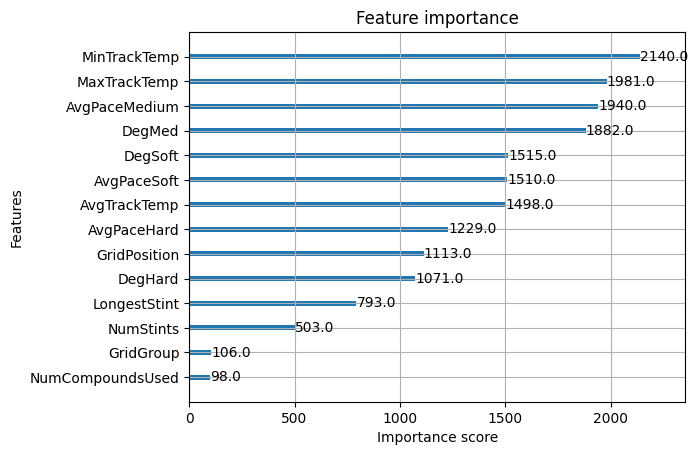

In [21]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(xgb, max_num_features=20)
plt.show()


In [22]:
import joblib
joblib.dump(best_xgb, "xgb_model.joblib")


['xgb_model.joblib']